# Show Effect of Scale on Discovery
Measure the number of stable MOFs discovered as a function of node-hours expended

In [23]:
# %matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
from itertools import chain

## Load in results from different scales
We have them in the summaries directory, labeled by number of nodes

In [24]:
summaries = []
for path in chain(
    Path("summaries").glob("*-nodes.csv.gz"),
    Path("summaries").glob("*-nodes_repeat-*.csv.gz"),
):
    count = int(path.name.split("-")[0])
    summaries.append([count, pd.read_csv(path)])
summaries.sort(key=lambda x: x[0])
print(f"Found {len(summaries)} runs:", " ".join(str(x[0]) for x in summaries))

Found 7 runs: 32 32 64 64 128 256 450


# Get the Average Rate for 32-nodes w/o Training
We'll use that as the "no MOFA" baseline

In [25]:
baseline_rate = []
for run in Path("summaries/").glob("64-nodes_no-retrain*.csv.gz"):
    summary = pd.read_csv(run)
    print(summary.columns)
    baseline_rate.append(
        summary["cumulative_found"].iloc[-1] / summary["walltime"].iloc[-1] * 3600
    )
baseline_rate = np.mean(baseline_rate)
print(f"Found a baseline rate of {baseline_rate:.2f} MOFs per hour")

Index(['name', 'topology', 'catenation', 'time', 'gas_storage.CO2',
       'structure_stability.uff', 'ligand.COO.name', 'ligand.COO.smiles',
       'ligand.COO.prompt_atoms', 'ligand.COO.metadata.model_version',
       'ligand.cyano.name', 'ligand.cyano.smiles', 'ligand.cyano.prompt_atoms',
       'ligand.cyano.metadata.model_version', 'model_version',
       'cumulative_found', 'walltime'],
      dtype='object')
Index(['name', 'topology', 'catenation', 'time', 'gas_storage.CO2',
       'structure_stability.uff', 'ligand.COO.name', 'ligand.COO.smiles',
       'ligand.COO.prompt_atoms', 'ligand.COO.metadata.model_version',
       'ligand.cyano.name', 'ligand.cyano.smiles', 'ligand.cyano.prompt_atoms',
       'ligand.cyano.metadata.model_version', 'model_version',
       'cumulative_found', 'walltime'],
      dtype='object')
Found a baseline rate of 274.74 MOFs per hour


In [26]:
baseline_rate

274.7368145771466

## Plot the Efficiency Over Time
Show that we get better at finding MOFs over time

In [27]:
sizes = sorted(set(x[0] for x in summaries))
cmap = plt.get_cmap("copper_r")
steps = np.linspace(0.2, 1.0, len(sizes))
colors = dict((size, cmap(step)) for size, step in zip(sizes, steps))

In [28]:
colors

{32: (0.9882350615917502, 0.62496, 0.398, 1.0),
 64: (0.7411762961938126, 0.46871999999999997, 0.2985, 1.0),
 128: (0.49411753079587517, 0.31248000000000004, 0.199, 1.0),
 256: (0.24705876539793759, 0.15623999999999993, 0.09949999999999998, 1.0),
 450: (0.0, 0.0, 0.0, 1.0)}

In [29]:
# lowest_slope

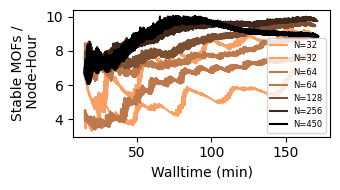

In [30]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

for count, summary in summaries:
    summary = summary.query(f"walltime > {15 * 60}")
    ax.plot(
        summary["walltime"] / 60,
        summary["cumulative_found"] / count / summary["walltime"] * 3600,
        "-",
        color=colors[count],
        label=f"N={count}",
    )
ax.legend(fontsize=6)

ax.set_xlabel("Walltime (min)")
ax.set_ylabel("Stable MOFs /\n Node-Hour")

fig.tight_layout()
fig.savefig("figures/stable-found-per-node-hour.png", dpi=320)
fig.savefig("figures/stable-found-per-node-hour.pdf")

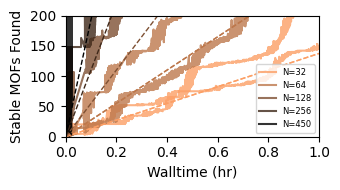

In [31]:
fig, ax = plt.subplots(figsize=(3.5, 2.0))

lowest_slope = np.mean(
    [
        summary["cumulative_found"].iloc[-1] / summary["walltime"].iloc[-1] * 3600
        for count, summary in summaries
        if count == min(colors.keys())
    ]
)
done = set()
for count, summary in summaries:
    ax.plot(
        summary["walltime"] / 3600,
        summary["cumulative_found"],
        "-",
        color=colors[count],
        alpha=0.8,
        label=f"N={count}" if count not in done else None,
    )
    done.add(count)

ax.set_xlim(0, 1.0)
ax.set_ylim([0, 200])
for count, summary in summaries:
    ax.plot(
        ax.get_xlim(),
        np.multiply(ax.get_xlim(), baseline_rate * count / 64),
        "--",
        lw=1,
        color=colors[count],
    )

ax.legend(fontsize=6)

ax.set_xlabel("Walltime (hr)")
ax.set_ylabel("Stable MOFs Found")

fig.tight_layout()
# fig.savefig("figures/stable-found-per-hour.png", dpi=320)
# fig.savefig("figures/stable-found-per-hour.pdf")
plt.show()